# Import libraries & Setup

In [1]:
##### base #####
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
from tqdm import tqdm
##### sklearn #####
from sklearn.model_selection import train_test_split
##### torch ######
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, ConcatDataset, Dataset, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

In [2]:
torch.cuda.is_available()

True

In [3]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


# Load and check MNIST dataset

In [4]:
# mean and std for MNIST dataset
mean, std = 0.1307, 0.3081

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

## Load MNIST training and testing dataset
original_train_ds = torchvision.datasets.MNIST(root = 'data/', train = True, transform = transform, download = True)
original_test_ds = torchvision.datasets.MNIST(root = 'data/', train = False, transform = transform, download = True)

print('Train dataset:', len(original_train_ds))
print('Test dataset:', len(original_test_ds))

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.56MB/s]

Train dataset: 60000
Test dataset: 10000


In [5]:
classes = original_train_ds.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
# data[a][b]: a is an image, b is its info where data[a][0]: data, data[a][1]: label
img_label = [original_train_ds[img][1] for img in range(len(original_train_ds))] # iterate through each image
label_count = dict(Counter(img_label))
print("Labels count:", label_count)

Labels count: {5: 5421, 0: 5923, 4: 5842, 1: 6742, 9: 5949, 2: 5958, 3: 6131, 6: 5918, 7: 6265, 8: 5851}


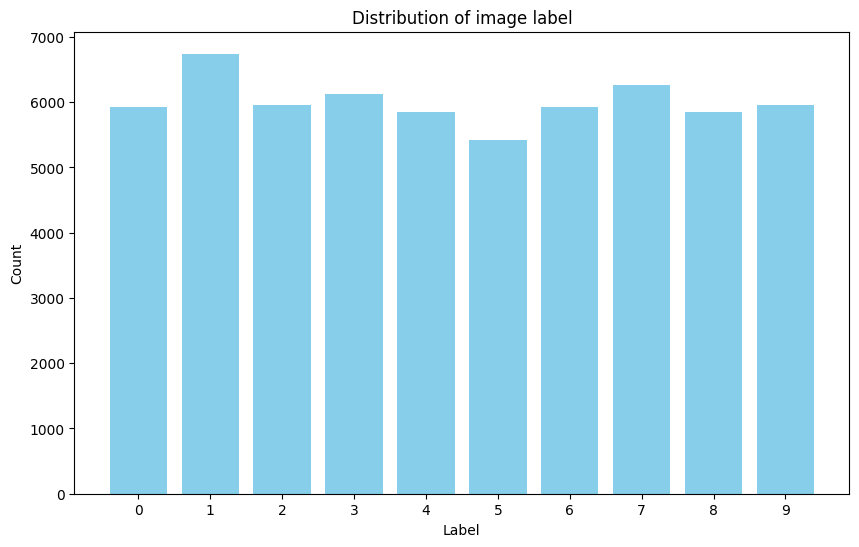

In [7]:
label_count = dict(sorted(label_count.items()))

plt.figure(figsize=(10,6))
plt.bar(label_count.keys(), label_count.values(), color = 'skyblue')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of image label')
plt.xticks(list(label_count.keys()))  # Ensure x-axis ticks are the keys
plt.show()

# SimCLR Dataset

In [8]:
def get_memory_params_model(model):
  # Model architecture
  print(model)
  print("Model memory allocation : {:.2e}".format(torch.cuda.memory_reserved(0) - torch.cuda.memory_allocated(0)))

  # Find total parameters and trainable parameters
  total_params = sum(p.numel() for p in model.parameters())
  print("{} total parameters.".format(total_params))
  total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print("{} training parameters.".format(total_trainable_params))

## Step 1: Data Agumentation

In [9]:
# Data augmentation for SimCLR
transform = transforms.Compose(
        [
            transforms.RandomResizedCrop(size=28, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
])

# SimCLR dataset
class SimCLRDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    # only get image, presume we don't know the label
    def __getitem__(self, idx):
        img, _ = self.dataset[idx]

        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)

        # img1 and img2 are a positive pair and all the other view are negative pairs for each image
        img1 = self.transform(img)  # Augmented view 1
        img2 = self.transform(img)  # Augmented view 2

        return img1, img2

    def __len__(self):
        return len(self.dataset)

In [10]:
simclr_train_ds = SimCLRDataset(original_train_ds, transform)
len(simclr_train_ds)

60000

In [11]:
# a positive pair
img1, img2 = simclr_train_ds[0] # 2 images of size 1,28,28

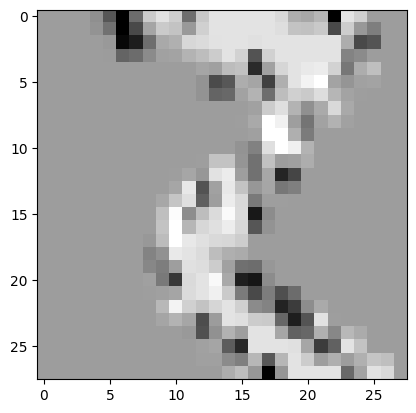

In [12]:
# use .permute() to put the channels as the last dimension when passing them to matplotlib
plt.imshow(img1.permute(1, 2, 0), cmap='gray') # shape to 28,28,1

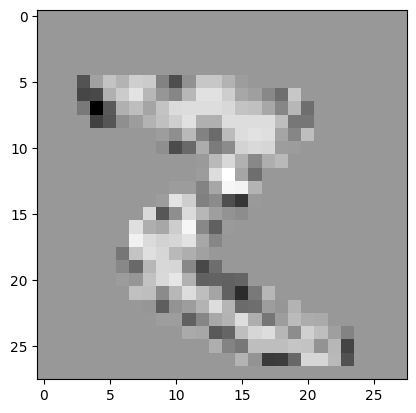

In [13]:
plt.imshow(img2.permute(1, 2, 0), cmap='gray') # shape to 28,28,1

# Class SimCLR architecture

## Step 2: Encoder

Both augmented images are passed through a shared encoder to extract features:

In [14]:
# encoder network (f)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(p=0.3),
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)  # Flatten
        return x

#  Step 3: Projection Head

The output of the encoder is passed through a projection MLP (small neural net) to map into a latent space where the contrastive loss is applied:

In [15]:
# projection head (g)
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=4096, output_dim=64):
        super(ProjectionHead, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.mlp(x)


# Step 4: Contrastive Loss

The Normalized Temperature-scaled Cross Entropy Loss (NT-Xent) is used to pull positive pairs closer and push negative pairs apart in the latent space.
It works on the cosine similarity between vectors.

In [16]:
# contrastive loss (NT-Xent Loss)
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        similarity_matrix = torch.mm(z_i, z_j.T)
        labels = torch.arange(z_i.size(0)).to(z_i.device)
        loss = F.cross_entropy(similarity_matrix / self.temperature, labels)
        return loss

# Step 5: SimCLR pretrain (Train encoder)

In [17]:
def get_memory_params_model(model):
  # Model architecture
  print(model)
  print("Model memory allocation : {:.2e}".format(torch.cuda.memory_reserved(0) - torch.cuda.memory_allocated(0)))

  # Find total parameters and trainable parameters
  total_params = sum(p.numel() for p in model.parameters())
  print("{} total parameters.".format(total_params))
  total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print("{} training parameters.".format(total_trainable_params))

Train the model to minimize contrastive loss. After training:

* Throw away the projection head
* Use the encoder output as the learned image representation

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder().to(device)
projection_head = ProjectionHead().to(device)
criterion = NTXentLoss(temperature=0.5)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(projection_head.parameters()), lr=1e-3)
simclr_loader = DataLoader(simclr_train_ds, batch_size=128, shuffle=True)

for epoch in range(15):
    encoder.train()
    projection_head.train()
    total_loss = 0
    for img1, img2 in simclr_loader:
        img1, img2 = img1.to(device), img2.to(device)
        h1, h2 = encoder(img1), encoder(img2)
        z1, z2 = projection_head(h1), projection_head(h2)
        loss = criterion(z1, z2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(simclr_train_ds)}")


Epoch 1, Loss: 0.03317543876568476
Epoch 2, Loss: 0.030388859991232555
Epoch 3, Loss: 0.02953399865627289
Epoch 4, Loss: 0.028974494926134745
Epoch 5, Loss: 0.028636564632256827
Epoch 6, Loss: 0.028401048882802326
Epoch 7, Loss: 0.028200008567174275
Epoch 8, Loss: 0.028060625477631888
Epoch 9, Loss: 0.027911455190181733
Epoch 10, Loss: 0.027827190307776133
Epoch 11, Loss: 0.02772761829296748
Epoch 12, Loss: 0.027629398274421693
Epoch 13, Loss: 0.027583098407586416
Epoch 14, Loss: 0.02751422833998998
Epoch 15, Loss: 0.027441519661744435


In [19]:
get_memory_params_model(encoder)

Encoder(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False

In [20]:
get_memory_params_model(projection_head)

ProjectionHead(
  (mlp): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
)
Model memory allocation : 3.82e+08
532672 total parameters.
532672 training parameters.


# Step 6: Classification with frozen encoder (trained encoder)

In [21]:
# Freeze encoder params
for param in encoder.parameters():
    param.requires_grad = False

## Linear probe

In [22]:
class LinearProbe(nn.Module):
    def __init__(self, encoder):
        super(LinearProbe, self).__init__()
        self.encoder = encoder
        self.linear = nn.Linear(4096, 10)  # adjust dim if needed

    def forward(self, x):
        x = self.encoder(x)
        x = self.linear(x)
        return x

In [23]:
linear_probe = LinearProbe(encoder).to(device)
get_memory_params_model(linear_probe)

LinearProbe(
  (encoder): Encoder(
    (layer1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.3, inplace=False)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.3, inplace=False)
    )
    (layer3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=1, di

## MLP (non linear) probe

In [24]:
class Classifier(nn.Module):
    def __init__(self, encoder):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.mlp = nn.Sequential(
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
            x = self.encoder(x)
            x = self.mlp(x)
            return x

In [25]:
classifier = Classifier(encoder).to(device)
get_memory_params_model(classifier)

Classifier(
  (encoder): Encoder(
    (layer1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.3, inplace=False)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.3, inplace=False)
    )
    (layer3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dil

# Train-validation split

## Supervised training to access performance

In [26]:
# Get labels to stratify the split on UNLABALED DATA
labels = []
for i in range(len(original_train_ds)) :
  _, label = original_train_ds[i]
  labels.append(label)

# Split indices if the dataset is composed of images
train_idx, val_idx = train_test_split(list(range(len(labels))),
                                              test_size = 0.2,
                                              stratify = labels,
                                              random_state = 42,
                                              shuffle=True)

train_set = torch.utils.data.Subset(original_train_ds, train_idx)
val_set = torch.utils.data.Subset(original_train_ds, val_idx)

# data[a][b]: a is an image, b is its info where data[a][0]: data, data[a][1]: label
print("Labels count for training set:", dict(Counter([train_set[img][1] for img in range(len(train_set))])))

Labels count for training set: {1: 5394, 3: 4905, 6: 4734, 8: 4681, 5: 4337, 7: 5012, 0: 4738, 4: 4674, 9: 4759, 2: 4766}


In [27]:
def train_classifier(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss
            total_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

        # Training accuracy
        train_accuracy = correct / total * 100

        # Validation loop
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                val_outputs = model(val_images)
                val_predictions = torch.argmax(val_outputs, dim=1)
                val_correct += (val_predictions == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_accuracy = val_correct / val_total * 100

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

In [28]:
import torch.optim as optim

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
criterion = torch.nn.CrossEntropyLoss()

## Train linear-probe

In [29]:
optimizer = optim.Adam(linear_probe.linear.parameters(), lr=1e-3)
train_classifier(linear_probe, train_loader, val_loader, criterion, optimizer, device, epochs=20)

Epoch 1/20, Loss: 0.1632, Train Accuracy: 95.29%, Validation Accuracy: 97.46%
Epoch 2/20, Loss: 0.0629, Train Accuracy: 98.17%, Validation Accuracy: 97.86%
Epoch 3/20, Loss: 0.0477, Train Accuracy: 98.47%, Validation Accuracy: 98.28%
Epoch 4/20, Loss: 0.0364, Train Accuracy: 98.86%, Validation Accuracy: 98.44%
Epoch 5/20, Loss: 0.0302, Train Accuracy: 99.07%, Validation Accuracy: 98.38%
Epoch 6/20, Loss: 0.0254, Train Accuracy: 99.22%, Validation Accuracy: 98.34%
Epoch 7/20, Loss: 0.0210, Train Accuracy: 99.36%, Validation Accuracy: 98.52%
Epoch 8/20, Loss: 0.0167, Train Accuracy: 99.51%, Validation Accuracy: 98.58%
Epoch 9/20, Loss: 0.0154, Train Accuracy: 99.49%, Validation Accuracy: 98.58%
Epoch 10/20, Loss: 0.0132, Train Accuracy: 99.60%, Validation Accuracy: 98.49%
Epoch 11/20, Loss: 0.0113, Train Accuracy: 99.69%, Validation Accuracy: 98.56%
Epoch 12/20, Loss: 0.0103, Train Accuracy: 99.69%, Validation Accuracy: 98.62%
Epoch 13/20, Loss: 0.0084, Train Accuracy: 99.78%, Validation

## Train non-linear probe

In [30]:
optimizer = optim.Adam(classifier.mlp.parameters(), lr=1e-3)
train_classifier(classifier, train_loader, val_loader, criterion, optimizer, device, epochs=20)

Epoch 1/20, Loss: 0.1578, Train Accuracy: 95.08%, Validation Accuracy: 97.38%
Epoch 2/20, Loss: 0.0581, Train Accuracy: 98.15%, Validation Accuracy: 97.65%
Epoch 3/20, Loss: 0.0486, Train Accuracy: 98.41%, Validation Accuracy: 98.17%
Epoch 4/20, Loss: 0.0365, Train Accuracy: 98.80%, Validation Accuracy: 98.35%
Epoch 5/20, Loss: 0.0311, Train Accuracy: 98.96%, Validation Accuracy: 97.69%
Epoch 6/20, Loss: 0.0248, Train Accuracy: 99.19%, Validation Accuracy: 97.98%
Epoch 7/20, Loss: 0.0249, Train Accuracy: 99.20%, Validation Accuracy: 98.18%
Epoch 8/20, Loss: 0.0199, Train Accuracy: 99.30%, Validation Accuracy: 98.22%
Epoch 9/20, Loss: 0.0175, Train Accuracy: 99.40%, Validation Accuracy: 98.34%
Epoch 10/20, Loss: 0.0167, Train Accuracy: 99.42%, Validation Accuracy: 98.38%
Epoch 11/20, Loss: 0.0156, Train Accuracy: 99.49%, Validation Accuracy: 98.41%
Epoch 12/20, Loss: 0.0141, Train Accuracy: 99.55%, Validation Accuracy: 98.00%
Epoch 13/20, Loss: 0.0131, Train Accuracy: 99.54%, Validation

# Final test evaluation

In [31]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    return accuracy

test_loader = DataLoader(original_test_ds, batch_size=128, shuffle=False)

In [32]:
accuracy = evaluate(linear_probe, test_loader, device)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 98.55%


In [33]:
accuracy = evaluate(classifier, test_loader, device)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 98.44%


Linear probe outperforming the non-linear MLP (even if just slightly) is a strong indicator that
* Encoder learned very effective representations during SimCLR pretraining.
* The features are linearly separable, which is the whole goal of contrastive learning, make it easy for a linear classifier to do the job.

# t-SNE plot with to visualize clusters for quality of representation

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


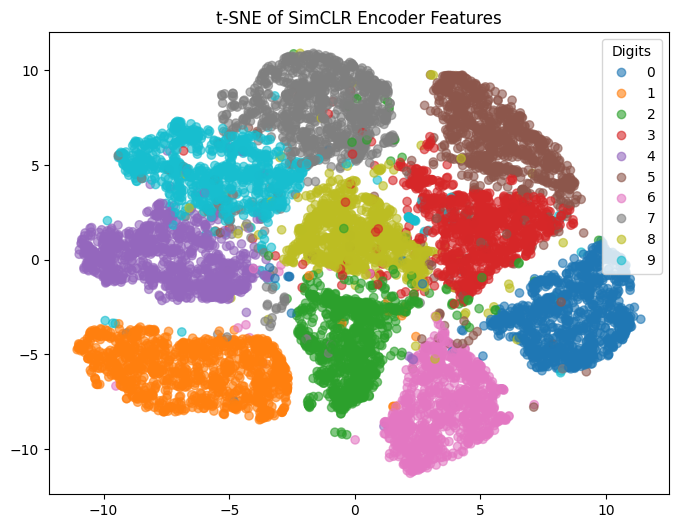

In [34]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Collect features from encoder
features = []
labels = []
encoder.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        out = encoder(images)
        features.append(out.cpu())
        labels.append(targets)

features = torch.cat(features).numpy()
labels = torch.cat(labels).numpy()

# 2. t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(features)

# 3. Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap='tab10', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("t-SNE of SimCLR Encoder Features")
plt.show()
